# Final Project: Analysis of Non-optimal Use of Tariff Plans of the Virtual Telephony Service.

A link to the dashboard: https://public.tableau.com/app/profile/anastasia.klein/viz/FinalProject_CallsStatistics/Dashboard

[dashboard 2 (other controls)](https://public.tableau.com/app/profile/anastasia.klein/viz/FinalProject_CallsStatistics/Dashboard2)

A link to the presentation: https://drive.google.com/file/d/1Wyiwu5qJ_DvesaBiBwBxY3dPhQA29vLA/view?usp=sharing

A link to documentation used in the analysis: https://drive.google.com/file/d/1mC_NtZTB2WiKgIpqmaqQ09RhMWT39XHq/view?usp=sharing

There is the virtual telephony service that provides a communication network for organizations and distributes incoming calls among their operators, connects them to each other, and allows outgoing calls as well. 

Statistics on the use of the service by operators of the clients are available: what tariff plan they use, how many calls they make, duration of calls, type of calls (internal or not, incoming or outgoing), information about missed calls. 

The purposes of the study are to:
* find clients with non-optimal plans and those who need bigger calling plans, reveal their characteristics
* estimate the reduction in revenue if all users switch to plans that are more beneficial to them

<a href='#section1'>1. Getting the data and studying the general information</a>

<a href='#section2'>2. Data preprocessing</a>
* <a href='#section2.1'>2.1 Data type replacement</a>
* <a href='#section2.2'>2.2 Examing and processing duplicates</a>
* <a href='#section2.3'>2.3 Examing and processing missing values</a>
* <a href='#section2.4'>2.4 Data consistency checking</a>
* <a href='#section2.5'>2.5 Investigation of outliers</a>

<a href='#section3'>3. Additional calculations</a>

<a href='#section4'>4. Exploratory data analysiss</a>

<a href='#section5'>5. Testing hypotheses</a>

<a href='#section6'>6. Overall conclusions</a>

In [1]:
# importing of libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

# some global constats for formatting the output string
BOLD = '\033[1m'
END = '\033[0m'

# function to run Shapiro-Wilk normality tests
def norm_test(samples, sample_descriptions, random_value_description):
    """The function runs Shapiro-Wilk normality tests 
    """ 

    print(BOLD + 'Q-Q Plots for duration of a trip for ' + ' and '.join(sample_descriptions) + ':' + END)
    fig, axes = plt.subplots(ncols=3, figsize=(6*3, 4))
    for i, (sample, descr) in enumerate(zip(samples, sample_descriptions)):
        st.probplot(sample.additional_revenue, dist="norm", plot=axes[i])
        axes[i].set_title('Probability Plot for ' + descr)
    plt.show()

    # Let's test the hypothesis that the distribution of sample is normal using the Shapiro-Wilk normality test
    print(BOLD + 'Shapiro-Wilk normality tests:' + END)
    alpha = 0.05
    for sample, descr in zip(samples, sample_descriptions):
        print('Hypotheses:')
        print(BOLD + 'H\u2080: ' + random_value_description + ' for ' + descr + ' is distributed normally' + END)
        print(BOLD + 'H\u2081: ' + random_value_description + ' for ' + descr + ' is not distributed normally' + END)
        norn_pvalue = st.shapiro(sample.additional_revenue)[1]
        print("Shapiro-Wilk normality test, p-value: ", norn_pvalue)
        if (norn_pvalue < alpha): 
            print("We reject the hypothesis H\u2080") 
        else: 
            print("We can't reject the hypothesis H\u2080") 
        print()
        
# function to run Mann-Whitney U test for two samples
def mann_whitneyu_test(sample1, sample2, description):
    """The function runs Mann-Whitney U test for two samples
    """ 
    
    print(BOLD + 'Mann-Whitney U test:' + END)
    alpha = 0.05
    print('Hypotheses:')
    print(BOLD + 'H\u2080: Sample distributions of ' + description + ' are equal.'+ END)
    print(BOLD +'H\u2081: Sample distributions of ' + description + ' are not equal.' + END)
    pvalue = st.mannwhitneyu(sample1, sample2, alternative='two-sided')[1]
    print("Mann-Whitney U test, p-value: ", pvalue)
    if (pvalue < alpha): 
        print("We reject the hypothesis H\u2080") 
    else: 
        print("We can't reject the hypothesis H\u2080") 
        
# function to calculate p-value for an independent proportion z-test
def proportions_diff_z_test(successes1, successes2, n1, n2, alternative = 'two-sided'):
    """The function calculates p-value for an independent proportion z-test
    """ 
    
    # proportion for success in the first group
    p1 = successes1 / n1
    # proportion for success in the second group
    p2 = successes2 / n2 
    # proportion in a combined dataset
    P = (successes1 + successes2) / (n1 + n2)
    
    # calculating z-test statistic
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

    # return p-value for independent proportion z-test
    if alternative == 'two-sided':
        return 2 * (1 - st.norm(0, 1).cdf(abs(z_stat)))
    
    if alternative == 'less':
        return st.norm(0, 1).cdf(z_stat)

    if alternative == 'greater':
        return 1 - st.norm(0, 1).cdf(z_stat)
    
# function to calculate p-value for the proportion z-test based on a contingency table
def proportions_diff_pvalue(contingency_table):
    """The function calculates p-value for an the proportion z-test based on a contingency table
    """
    
    successes1 = contingency_table.iloc[0, 0]
    successes2 = contingency_table.iloc[1, 0]
    
    n1 = contingency_table.iloc[0, 1]
    n2 = contingency_table.iloc[1, 1]

    return proportions_diff_z_test(successes1, successes2, n1, n2)

# function to run the independent proportion z-test based on a contingency table
def z_test(contingency_table, description):
    """The function runs the independent proportion z-test based on a contingency table
    """
    
    print(BOLD + 'Two-Proportions Z-Test:' + END)
    alpha = 0.05
    print('Hypotheses:')
    print(BOLD + 'H\u2080: The proportions of ' + description + ' are equal.'+ END)
    print(BOLD +'H\u2081: The proportions of ' + description + ' are not equal.' + END)
    pvalue = proportions_diff_pvalue(contingency_table)
    print("The proportion difference z-test, p-value: ", pvalue)
    if (pvalue < alpha): 
        print("We reject the hypothesis H\u2080") 
    else: 
        print("We can't reject the hypothesis H\u2080") 

## 1. Getting the data and studying the general information
<a id='section1'></a>

In [2]:
# reading files that contain the virtual telephony servise data 
df = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')

# creating lists of tables and descriptions to them
tables = [df, clients]
descriptions = ['call statistics', 'clients info']

for i, (table, description) in enumerate(zip(tables, descriptions)):
    # looking at the data's general information.
    print(BOLD + 'General inforamation about the table contains ' 
          + description + ':' + END)
    table.info()
    print()
    
    # looking at the first few rows in a table
    print(BOLD + 'The first rows of the table contains ' 
      + description + ':' + END)
    display(table.head())
    print()

General inforamation about the table contains call statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

The first rows of the table contains call statistics:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25



General inforamation about the table contains clients info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB

The first rows of the table contains clients info:


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


The dataset contains daily reports on internal, external, incoming and outgoing calls of 732 clients of the virtual telephony service.

There are 8,172 missing values in the `'operator_id'` column, which is about 15% of all data. There are also 117 missing values in the `'internal'` column.

The `'internal'` column appears to contain boolean values, but it has null values as well, therefor object type is used. For the `'operator_id'` column float64 is used, but it seems to contain integer type. For the `'date'` and `'date_start'` columns, it's nessecary to change the type to datetime to make it convenient to work with dates.

In [3]:
# Let's take a closer look at the values that the features take.

# Let's look at the values that take categorical features 
print(BOLD + 'Categorical features:' + END)
for table, cols, descr in zip(tables, [['direction','internal'], ['tariff_plan']],
                              descriptions):
    print("The columns with categorical values in the table containing data on " + BOLD + descr + END + ':')
    pd.set_option('display.max_colwidth', -1)
    display(table[cols].agg(['unique', 'nunique']).T)
    print()
    
print(BOLD + 'Features containg ID values:' + END)
display(df[['user_id', 'operator_id']].agg(['nunique', 'min', 'max']).T)

# Let's look at the values that take numerical features. 
print(BOLD + 'Numerical features:' + END)
display(df[['calls_count', 'call_duration', 'total_call_duration']].describe().round(2).T)
    
# Let's look at date range in the dataset
print(BOLD + 'Features containing dates:' + END)
for table, date_cols, descr in zip(tables, [['date'], ['date_start']], descriptions):
    print("Date range in the table containing data on " + BOLD + descr + END + ':')
    display(table[date_cols].agg(['min', 'max']))

print(BOLD + 'Checking types:' + END)
# checking if the 'operator_id' column has only integer values
print("Are all values of 'operator_id' column integer?", BOLD, 
      df[df.operator_id.notnull()].operator_id.apply(float.is_integer).all(), END)
print()

# Checking if the 'date' column contains time (hours, minutes, seconds)
print("Does the 'date' column contain hours?", BOLD, 
      (pd.to_datetime(df.date).map(lambda x: x.hour)>0).any(), END)

print("Does the 'date' column contain minutes?", BOLD, 
      (pd.to_datetime(df.date).map(lambda x: x.minute)>0).any(), END)

print("Does the 'date' column contain seconds?", BOLD, 
      (pd.to_datetime(df.date).map(lambda x: x.second)>0).any(), END)

Categorical features:
The columns with categorical values in the table containing data on call statistics:


,unique,nunique
direction,"[in, out]",2
internal,"[False, True, nan]",2



The columns with categorical values in the table containing data on clients info:


,unique,nunique
tariff_plan,"[A, C, B]",3



Features containg ID values:


,nunique,min,max
user_id,307.0,166377.0,168606.0
operator_id,1092.0,879896.0,973286.0


Numerical features:


,count,mean,std,min,25%,50%,75%,max
calls_count,53902.0,16.45,62.92,1.0,1.0,4.0,12.0,4817.0
call_duration,53902.0,866.68,3731.79,0.0,0.0,38.0,572.0,144395.0
total_call_duration,53902.0,1157.13,4403.47,0.0,47.0,210.0,902.0,166155.0


Features containing dates:
Date range in the table containing data on call statistics:


,date
min,2019-08-02 00:00:00+03:00
max,2019-11-28 00:00:00+03:00


Date range in the table containing data on clients info:


,date_start
min,2019-08-01
max,2019-10-31


Checking types:
Are all values of 'operator_id' column integer?  True 

Does the 'date' column contain hours?  False 
Does the 'date' column contain minutes?  False 
Does the 'date' column contain seconds?  False 


There are three types of tariff plans in the dataset (calling plans A, B and C).

The dataset contains reports for only 307 clients, which is about 40% of all clients registered from August 1st, 2019 to October 31st, 2019 (see table with clients info). There are reports from August 2nd, 2019 to November 28th, 2019.

An average number calls in a report is 4, the maximum is 4817 that corresponds to continuous calls every 18 seconds throughout the day.

An average call duration is 38 and with waiting time is 210 units. There can be both minutes and seconds. This information is not specified in the specification. The maximum call duration including waiting time is 166155, which corresponds to 2 days of continuous calling, assuming the duration is in seconds. This value looks like an outlier.

We could use Int32 type for the `'operator_id'` column and discard time in the `'date'` column for the convenience of further calculations.

In [4]:
# Let's see if clients have reports every day
print(BOLD + 'Number of clients with reports by date for last 2 weeks:' + END)
display(df.groupby('date').user_id.nunique().tail(14).reset_index().rename(columns={'user_id':'number of clients'}))

Number of clients with reports by date for last 2 weeks:


,date,number of clients
0,2019-11-15 00:00:00+03:00,168
1,2019-11-16 00:00:00+03:00,95
2,2019-11-17 00:00:00+03:00,93
3,2019-11-18 00:00:00+03:00,166
4,2019-11-19 00:00:00+03:00,172
5,2019-11-20 00:00:00+03:00,177
6,2019-11-21 00:00:00+03:00,163
7,2019-11-22 00:00:00+03:00,168
8,2019-11-23 00:00:00+03:00,106
9,2019-11-24 00:00:00+03:00,89


Clients do not have reports every day. Most likely some reports contain data for several days.

<a id='section2'></a>
## 2. Data Preprocessing

<a id='section2.1'></a>
###  2.1 Data Type Replacement

In [5]:
# converting date columns to datatime type:
df['date'] = df.date.astype('datetime64[D]')
clients['date_start'] = pd.to_datetime(clients.date_start, format='%Y-%m-%d')

# converting excess type with help of astype() method:
df['operator_id'] = df.operator_id.astype('Int32')

The type for the `'date'` and `'date_start'` columns has been changed to datetime to make them convenient to work with it. Excess types for `'operator_id'` column has been converted to proper ones. 

<a id='section2.2'></a>
###  2.2 Examing and Processing Duplicates

In [6]:
# Let's look at duplicates  
print(BOLD + 'Full duplicates:' + END)
for table, descr in zip(tables, descriptions):
    print("The number of full duplicates in the table containing data on " + BOLD + descr + END 
          + ' is {}, which is {:.1%} of all data.'.format(len(table[table.duplicated()]),
                                                        len(table[table.duplicated()])/len(table)))

Full duplicates:
The number of full duplicates in the table containing data on call statistics is 4900, which is 9.1% of all data.
The number of full duplicates in the table containing data on clients info is 0, which is 0.0% of all data.


There are almost 5 thousand full duplicate rows in the report table. It makes sense to delete them.

In [7]:
# Let's drop duplicates
df.drop_duplicates(inplace=True)

The duplicate rows have been removed.

<a id='section2.3'></a>
### 2.3 Examing and Processing Missing Values

__Investigating missing values in the 'operator_id' column__ 

In [8]:
# Let's investigate missing values in the 'operator_id' column
users_with_missing_operator_id = df[df.operator_id.isnull()].user_id.unique()
print(BOLD + "There are {} users with missing 'operator_id' values."\
                 .format(len(users_with_missing_operator_id)) + END)

users_with_all_null_operator_id = df[df.user_id.isin(users_with_missing_operator_id)]\
    .groupby('user_id').operator_id.nunique().reset_index().query('operator_id==0').user_id
print(BOLD + "There are {} users with only missing 'operator_id' values."\
                 .format(len(users_with_all_null_operator_id)) + END)

There are 305 users with missing 'operator_id' values.
There are 17 users with only missing 'operator_id' values.


305 out of 307 clients with reports have missing values in the `'operator_id'` column. 

The missing value of the `'operator_id'` column might affect further calculations of the cost of communication services as each individual operator is charged. This is especially true for clients who only have null `'operator_id'` values, since then the operator's cost will not be calculated.

In [9]:
# Let's investigate clients who only have null 'operator_id' values
# if there are no recurring days with the same 'user_id', 'direction', 'internal', 'is_missing_call' values
# since this would mean they most likely have only one operator.
print(BOLD + "Duplicated date for the same 'user_id', 'direction', 'internal', 'is_missing_call' values "
           + "for clients who only have null 'operator_id' values:" + END)
display(df[df.user_id.isin(users_with_all_null_operator_id)][df[df.user_id.isin(users_with_all_null_operator_id)]\
           .duplicated(['user_id', 'date', 'direction', 'internal', 'is_missed_call'], keep=False)])


Duplicated date for the same 'user_id', 'direction', 'internal', 'is_missing_call' values for clients who only have null 'operator_id' values:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


Most likely, clients who only have null values for `'operator_id'` only have one operator. We can set the `'user_id'` value as the `'operator_id'` value. Note in the dataset `'user_id'` and `'operator_id'` are not intercect (see general info, their min and max values).

In [10]:
# Let's replace 'operator_id' with 'user_id' for clients with only null values for 'operator_id'

# storing old operator_id values to a separate feature
df['operator_id_old'] = df['operator_id']

# replacing 'operator_id' with 'user_id' 
df.loc[df.user_id.isin(users_with_all_null_operator_id), 'operator_id'] \
    = df.loc[df.user_id.isin(users_with_all_null_operator_id), 'user_id'] 

We have replaced `'operator_id'` with `'user_id'` for clients with only null values for `'operator_id'`.

In [11]:
# Let's look at the number of missing 'operator_id' values by the 'is_missed_call' column
print(BOLD + "Number of reports of missed and non-missed calls with null value in the 'operator_id' column:" + END)
display(df[df.operator_id.isnull()].is_missed_call.value_counts())

Number of reports of missed and non-missed calls with null value in the 'operator_id' column:


True     7244
False    113 
Name: is_missed_call, dtype: int64

Most calls with null value in the `'operator_id'` column in the report are missing. Most likely, the fact that the call was missed is the reason for the absence of an `'operator_id'`. Since we don't need to further evaluate the quality of each operator's work, we can fill the `'operator_id'` column in these cases with any client operator identifier, for instance, the first one that comes across.

But in 103 cases the call was not missed.

In [12]:
# Let's fill the `'operator_id'` column for missed calls with the first client operator identifier that comes across
for user in df[df.is_missed_call==True].user_id.unique():
    df.loc[(df.user_id==user)&(df.is_missed_call==True)&df.operator_id.isnull(), 'operator_id'] \
        = df[(df.user_id==user)&df.operator_id.notnull()].operator_id.unique()[0]

We have filled in missing `'operator_id'` values for missed calls with the first client operator identifier that comes across.

In [13]:
# Let's take a closer look at the missing 'operator_id' values for non-missed calls
print(BOLD + "Number of operators and number of rows with null 'operator_id' values by users:" + END)
users_with_missing_operator = df[df.operator_id.isnull()&(df.is_missed_call==False)].user_id.unique()
display(df[df.operator_id.notnull()&df.user_id.isin(users_with_missing_operator)]\
            .groupby('user_id').agg({'operator_id':'nunique'})\
        .join(df[df.operator_id.isnull()&(df.is_missed_call==False)].user_id.value_counts())\
            .rename(columns={'operator_id':'operator_num', 'user_id':'missing_operator_rows_num (non-missed call)'}))

Number of operators and number of rows with null 'operator_id' values by users:


,operator_num,missing_operator_rows_num (non-missed call)
user_id,,
166399,1,2
166503,6,3
166782,5,16
166916,16,1
166946,2,1
167402,1,1
167819,4,1
167977,5,1
168018,5,3


When a client has only one operator we have a couple of gaps in the dataset and we can restore the `'operator_id'` values with this operator. In other cases, it is difficult to restore them. 

In [14]:
# Let's fill the missing 'operator_id' values for clients having only one operator with identifier of its operator.
users_with_one_operator = df[df.operator_id.notnull()].groupby('user_id').operator_id.nunique().reset_index()\
                              .query('operator_id==1').user_id

for user in users_with_one_operator:
    df.loc[(df.user_id==user)&df.operator_id.isnull(), 'operator_id'] \
        = df[(df.user_id==user)&df.operator_id.notnull()].operator_id.unique()[0]

We have filled in the missing `'operator_id'` values for clients who have only one operator with the value of that operator's identifier.

In [15]:
# Let's see if there are any months when all 'operator_id' values are missing for a client
print(BOLD + "There are all missing `'operator_id'` values for the client within a month:" + END)
display(df.groupby(['user_id',
                    df[df.user_id.isin(users_with_missing_operator_id)].date.dt.date.astype('datetime64[M]')])\
            .operator_id.nunique().reset_index().query('operator_id==0'))

There are all missing `'operator_id'` values for the client within a month:


,user_id,date,operator_id


There are no months when all `'operator_id'` values are missing for a client. We can assume that within a month there are reports for all operators of the client and the missing values will not lead to the fact that the number of operators who made calls during the month will be incorrectly calculated and, accordingly, the monthly cost of communication services. 

__Investigating missing values in the 'internal' column.__

In [16]:
# Let's investigate missing values in the 'internal' column
print(BOLD + "Number of reports of incoming and outgoing calls with missing value in the 'internal' column:" + END)
display(df[df.internal.isnull()].direction.value_counts())

Number of reports of incoming and outgoing calls with missing value in the 'internal' column:


in     108
out    2  
Name: direction, dtype: int64

Most calls with missing value in the `'internal'` column in the report are incoming. All incoming calls are free. Thus, lack of information about whether the call was internal or external will not affect further calculations of the cost of calls. These missing values can be left as null.

In [17]:
# Let's look at reports on outgoing calls with missing values in the 'internal' column.
print(BOLD + "The reports on outgoing calls with missing values in the 'internal' column:" + END)
display(df[df.internal.isnull()&(df.direction=='out')])

The reports on outgoing calls with missing values in the 'internal' column:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,operator_id_old
21004,167016,2019-10-22,out,NaN,916424,True,3,0,196,NaN
51367,168291,2019-11-27,out,NaN,946454,True,3,0,93,NaN


Outgoing calls with lack of `'internal'` value are missing calls (`'is_missed_call'` is True). We assume that missed calls are free of charge. Thus, lack of information about whether the call was internal or external will not affect further calculations of the cost of calls as well. These missing values can be restored with any `'internal'` value in oder to estimate charges for the number of operators, and not for calls cost according to these reports.

In [18]:
# Let's fill the missing 'internal' values with the most popular value of outgoing calls for the client

# storing old 'internal' values to a separate feature
df['internal_old'] = df['internal']

for user in df[df.internal.isnull()&(df.direction=='out')].user_id.unique():
    df.loc[(df.user_id==user)&df.internal.isnull()&(df.direction=='out'), 'internal'] \
        = df[(df.user_id==167016)&(df.direction=='out')].internal.value_counts().index[0]

We have filled in missing `'internal'` values with the most popular `'internal'` value of outgoing calls for the client.

<a id='section2.4'></a>
### 2.4 Data Сonsistency Сhecking

In [19]:
# Let's consider the cases when missed calls have a non-zero call duration.
print(BOLD + 'The number of cases when missed calls have a non-zero call duration is {}, which is {:.1%} of all data.'\
             .format(len(df[(df.is_missed_call==True)&(df.call_duration>0)]),
                     len(df[(df.is_missed_call==True)&(df.call_duration>0)])/len(df)), END)

The number of cases when missed calls have a non-zero call duration is 296, which is 0.6% of all data. 


Some calls with a missed call status have a non-zero duration in the dataset. To restore data consistency, we need change the status to not missed or set the duration to zero.

In [20]:
# Let's look at the number of missed calls with a non-zero duration by direction
print(BOLD + 'Number of reports of missed incoming and outgoing calls with a non-zero duration:' + END)
display(df[(df.is_missed_call==True)&(df.call_duration>0)].direction.value_counts())

Number of reports of missed incoming and outgoing calls with a non-zero duration:


in     275
out    21 
Name: direction, dtype: int64

Most missed calls with a non-zero duration are incoming. All incoming calls are free. Thus, the lack of information on whether the call was mistakenly marked as missed or the call duration was erroneously recorded will not affect further calculations of the cost of calls. In this cases, the call duration can be set to zero.

In [21]:
# Let's take a closer look at all missed outgoing calls with a non-zero duration
print(BOLD + 'All missed outgoing calls with a non-zero duration:' + END)
display(df[(df.is_missed_call==True)&(df.call_duration>0)&(df.direction=='out')])
print()

print(BOLD + 'Comparison of missed outgoing calls of a non-zero duration with answered ones:' + END)
display(df[(df.is_missed_call==True)&(df.call_duration>0)&(df.direction=='out')]\
            .merge(df[df.is_missed_call==False], on=['user_id', 'date', 'direction', 'internal', 'operator_id'],
                   suffixes=('_miss', '_non_miss'))\
            .assign(avg_call_duration_miss=lambda x: x.call_duration_miss/x.calls_count_miss,
                    avg_call_duration_non_miss=lambda x: x.call_duration_non_miss/x.calls_count_non_miss)\
            [['user_id', 'date', 'calls_count_miss', 'calls_count_non_miss',
              'call_duration_miss', 'call_duration_non_miss',
              'avg_call_duration_miss', 'avg_call_duration_non_miss']].round(2))

All missed outgoing calls with a non-zero duration:


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,operator_id_old,internal_old
16129,166916,2019-09-26,out,True,906394,True,1,25,50,906394,True
16261,166916,2019-10-03,out,True,906406,True,3,3,39,906406,True
16300,166916,2019-10-06,out,True,906400,True,2,19,34,906400,True
16363,166916,2019-10-09,out,True,906408,True,7,1,32,906408,True
16409,166916,2019-10-13,out,True,906400,True,6,27,43,906400,True
16709,166916,2019-10-29,out,True,906412,True,4,87,164,906412,True
16796,166916,2019-11-04,out,True,906412,True,3,71,82,906412,True
16842,166916,2019-11-06,out,True,906416,True,4,148,239,906416,True
16973,166916,2019-11-11,out,True,906412,True,8,35,64,906412,True
16986,166916,2019-11-12,out,True,906412,True,4,17,29,906412,True



Comparison of missed outgoing calls of a non-zero duration with answered ones:


,user_id,date,calls_count_miss,calls_count_non_miss,call_duration_miss,call_duration_non_miss,avg_call_duration_miss,avg_call_duration_non_miss
0,166916,2019-09-26,1,2,25,48,25.00,24.00
1,166916,2019-10-03,3,5,3,187,1.00,37.40
2,166916,2019-10-06,2,2,19,35,9.50,17.50
3,166916,2019-10-09,7,3,1,70,0.14,23.33
4,166916,2019-10-13,6,6,27,181,4.50,30.17
5,166916,2019-10-29,4,8,87,496,21.75,62.00
6,166916,2019-11-04,3,10,71,539,23.67,53.90
7,166916,2019-11-06,4,2,148,1572,37.00,786.00
8,166916,2019-11-11,8,9,35,632,4.38,70.22
9,166916,2019-11-12,4,4,17,498,4.25,124.50


The specified duration for missed calls is small and almost always shorter than the normal call duration, so we can set zero for the duration of the call indicated as missed.

Note outgoing missed calls with a non-zero duration are internal.

In [22]:
# Let's set zero for the duration of the call indicated as missed

# storing old 'call_duration' values to a separate feature
df['call_duration_old'] = df['call_duration']

# setting zero for the duration of the call indicated as missed
df.loc[(df.is_missed_call==True)&(df.call_duration>0), 'call_duration'] = 0

We have set zero for the duration of the call indicated as missed.

<a id='section2.5'></a>
### 2.5 Investigation of Outliers

In [23]:
# Let's investigate the outliers in the features corresponding to the call duration

# Let's calculate monthly total call duration per operator
# to neutralize the fact that customer reports are not available every day 
# and the report may contain data for several days. 

# calculating the number of operator for each client
operator_num = df[df.operator_id.notnull()]\
                   .groupby(['user_id', df.date.dt.date.astype('datetime64[M]')]).operator_id.nunique()\
                        .reset_index().rename(columns={'operator_id':'operator_num'})

# calculating monthly total call duration and the number of operators for each client
total_monthly_call_duration = df.groupby(['user_id', df.date.dt.date.astype('datetime64[M]')])\
                                     .agg({'total_call_duration':'sum'}).reset_index()\
                                  .merge(operator_num, on=['user_id', 'date'], how='left').fillna(0)

# calculating the number of days for each month
day_num_per_month = df.groupby(df.date.dt.date.astype('datetime64[M]')).date.nunique()

# calculating call duration per operator per day
total_monthly_call_duration = total_monthly_call_duration\
                                  .merge(day_num_per_month, left_on='date', right_index=True, suffixes=('', '_num'))\
                                  .assign(call_duration_per_operator_per_day=lambda x: x.total_call_duration\
                                                                                          /x.operator_num/x.date_num)

print(BOLD + 'Describe statistics for average call duration per operator per day:' + END)
display(total_monthly_call_duration.agg({'call_duration_per_operator_per_day':'describe'}).round(2).T)

more_than_24x60 = total_monthly_call_duration.query('call_duration_per_operator_per_day>24*60')
print(BOLD + 'Number of months when call duration per operator per day more than 24*60 units is {}, which is {:.1%}'\
      .format(len(more_than_24x60), len(more_than_24x60)/len(total_monthly_call_duration)), 
      'of all monthly data. It corresponds to {} clients.'.format(more_than_24x60.user_id.nunique()) + END)
print()

more_than_24x60x60 = total_monthly_call_duration.query('call_duration_per_operator_per_day>24*60*60')
print(BOLD + 'Number of months when call duration per operator per day more than 24*60*60 units is {}.'\
      .format(len(more_than_24x60x60)), END)

Describe statistics for average call duration per operator per day:


,count,mean,std,min,25%,50%,75%,max
call_duration_per_operator_per_day,799.0,659.83,3854.45,0.0,7.89,71.16,392.0,88735.62


Number of months when call duration per operator per day more than 24*60 units is 83, which is 10.4% of all monthly data. It corresponds to 48 clients.

Number of months when call duration per operator per day more than 24*60*60 units is 1. 


If we assume that the duration of calls in the dataset is in minutes, then for more than 10% of the data the average call duration per operator per day is more than a day (more than 24 * 60). This issue does not accur if we assume that the duration is in seconds (there is no call duration per operator per day more than 24 * 60 * 60).

We will assume that the duration is indicated in seconds.

However, the maximum duration of 85833.77 per operator per day will be almost a day without 10 minutes, assuming the duration is in seconds.

Clients calling more than 8 hours per day per operator in avarage:


,user_id,date,total_call_duration,operator_num,date_num,call_duration_per_operator_per_day
79,166582,2019-08-01,1969471,2,31,31765.661290
80,166582,2019-09-01,5324137,2,30,88735.616667
81,166582,2019-10-01,4451196,3,31,47862.322581



Total call duration in hours for each operator of the clients with id = 166582:


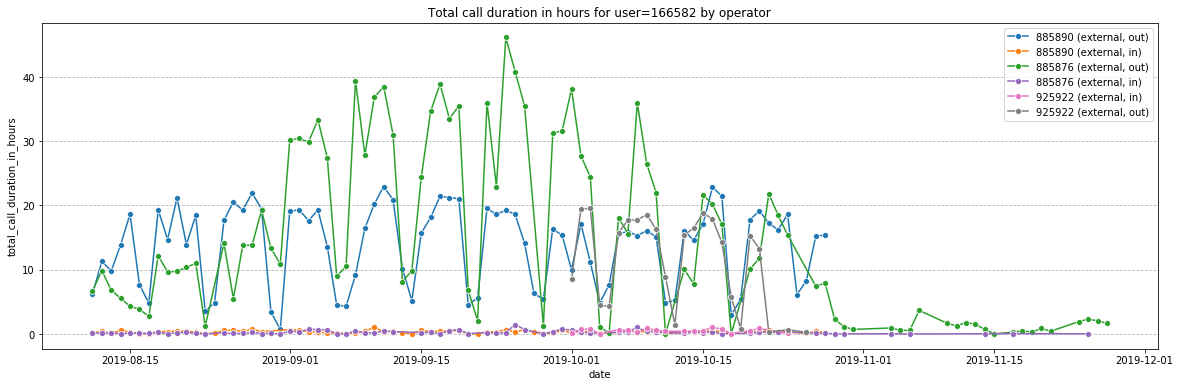

In [24]:
# Let's limit the duration of calls per day to eight 8 (more than 28,800 seconds)
# and take a closer look at clients who call longer than this time.
print(BOLD + 'Clients calling more than 8 hours per day per operator in avarage:' + END)
more_8_hours_per_day = total_monthly_call_duration.query('call_duration_per_operator_per_day>8*60*60')
display(more_8_hours_per_day)
print()

# plotting charts of call duration for each operator of clients calling more than 8 hours per day per operator
for user in more_8_hours_per_day.user_id.unique():
    print(BOLD + 'Total call duration in hours for each operator of the clients with id = {}:'.format(user) + END)
    fig, ax = plt.subplots(figsize=(20, 6))
    for operator in df[df.user_id==user].operator_id.unique():
        for direc in df[df.operator_id==operator].direction.unique(): 
            for inter in df[df.operator_id==operator].internal.unique():
                internal_str = 'internal' if inter else 'external'
                data = df[(df.operator_id==operator)&(df.direction==direc)
                          &(df.internal==inter)&(df.direction==direc)&(df.is_missed_call==False)]\
                           .assign(total_call_duration_in_hours = lambda x: x.total_call_duration/60/60)
                sns.lineplot(x='date', y='total_call_duration_in_hours', ax=ax, marker='o', linestyle='',
                             label=str(operator)+' ('+ internal_str +', ' + direc + ')', data=data);
    ax.set_title('Total call duration in hours for user=' + str(user) + ' by operator')
    ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)


It looks like there is daily reporting for each operator, but the duration of calls for some operators is 24 hours or even double this value. Probably it is worth deleting this user completely, as having inaccurate data.

In [25]:
# Let's drop the client with inaccurate data
df.drop(df.loc[df.user_id==166582].index, inplace=True)

We have deleted client data with inaccurate values of the duration of calls.

## 3. Additional calculations: determination of the optimal tariff plan for each client and calculation of additional revenue from each client using non-optimal tariffs
<a id='section3'></a>

In [26]:
# Let's record the tariff costs in the appropriate tables and variables.
print(BOLD + 'The virtual telephony service pricing:' + END)
print()

# creating table with tariff plans for minutes costs
plans = pd.DataFrame({'tariff_plan': ['A', 'B', 'C', 'A', 'B', 'C'],
                      'minutes_included': [2000, 2000, 2000, 0, 0, 0],
                      'internal' : [True, True, True, False, False, False],
                      'per_ex_minute': [0.1, 0.15, 0.3, 0.4, 0.5, 0.7]})

# creating a pivot table of tariff plans for more convenient work with
plans_pivot = plans.pivot_table(index=['internal', 'minutes_included'], columns=['tariff_plan'],
                                values='per_ex_minute')

print('Tariff plans, minutes tarification:')
display(plans_pivot)
plans_pivot.reset_index(inplace=True)
print()

# creating table with tariff plans for monthly pays
plans_monthly_pays = pd.DataFrame({'tariff_plan': ['A', 'B', 'C'],
                                   'monthly_pay': [5000, 2000, 1000]})

print('Tariff plans, monthly pays:')
display(plans_monthly_pays)
print()

# set monthly cost of one operator
operator_cost = 100
print('The monthly cost of one operator is', operator_cost)

The virtual telephony service pricing:

Tariff plans, minutes tarification:


,tariff_plan,A,B,C
internal,minutes_included,,,
False,0,0.4,0.50,0.7
True,2000,0.1,0.15,0.3



Tariff plans, monthly pays:


,tariff_plan,monthly_pay
0,A,5000
1,B,2000
2,C,1000



The monthly cost of one operator is 100


We have recorded the tariff costs in the appropriate tables and variables, in the future it will be easy to change the calculations in the case of tariff plans changing.

In [27]:
# Let's caluclate the monthly cost of communication services in all tariffs for each client 
# and determine the optimal one.
# We will calculate the monthly clients costs 
# and additional revenue of the service from client using non-optimal tariffs as well. 

# function for getting monthly pay by tariff plan
def get_monthly_pays(tariff_plan):
    return plans_monthly_pays[plans_monthly_pays.tariff_plan==tariff_plan].monthly_pay.values[0]

# suppose that operators who made calls during a given month are charged.
operator_count = df[df.operator_id.notnull()]\
                   .groupby(['user_id', df.date.dt.date.astype('datetime64[M]')]).operator_id.nunique()\
                      .reset_index().rename(columns={'operator_id':'operator_count'})

# calculating monthly duration of outgoing calls
monthly_call_duration = df[(df.direction=='out')]\
                            .groupby(['user_id', df.date.dt.date.astype('datetime64[M]'), 'internal'])\
                                .agg({'call_duration':'sum', 'calls_count':'sum'}).reset_index()

# recalculating call duration in minutes
monthly_call_duration['call_duration'] = monthly_call_duration.call_duration / 60

# adding tariff plans and calculating internal and external calls costs in each tariff plan
costs = monthly_call_duration.merge(plans_pivot, on=['internal'])\
            .assign(calls_costs_A=lambda x: np.where(x.call_duration > x.minutes_included, \
                                                        (x.call_duration - x.minutes_included) * x.A, 0),
                
                    calls_costs_B=lambda x: np.where(x.call_duration > x.minutes_included, \
                                                        (x.call_duration - x.minutes_included) * x.B, 0),

                    calls_costs_C=lambda x: np.where(x.call_duration > x.minutes_included, \
                                                        (x.call_duration - x.minutes_included) * x.C, 0),

                    call_duration_internal=lambda x: np.where(x.internal, x.call_duration, 0),
                    call_duration_external=lambda x: np.where(x.internal, 0, x.call_duration),
                    calls_count_internal=lambda x: np.where(x.internal, x.calls_count, 0),
                    calls_count_external=lambda x: np.where(x.internal, 0, x.calls_count))

# calculating total monthly calls costs in each tariff plan
costs = costs.groupby(['user_id', 'date'])\
            .agg({'call_duration_internal':'sum', 'call_duration_external':'sum', 'call_duration':'sum',
                  'calls_count_internal':'sum', 'calls_count_external':'sum', 'calls_count':'sum',
                  'calls_costs_A':'sum', 'calls_costs_B':'sum', 'calls_costs_C':'sum'}).reset_index()

# Let's calculate total monthly costs in each tariff plan and determining the optimal plan.
# merging with info about the number of operators, 
# in case when the calls are only incoming set zero for call cost in all tariff plans
costs = costs.merge(operator_count, on=['user_id', 'date'], how='right')\
            .fillna({'calls_costs_A':0, 'calls_costs_B':0, 'calls_costs_C':0})\
            .assign(calls_count_per_operator=lambda x: x.calls_count/x.operator_count,
                    call_duration_per_operator=lambda x: x.call_duration/x.operator_count,
                    call_duration_internal_per_operator=lambda x: x.call_duration_internal/x.operator_count,
                    call_duration_external_per_operator=lambda x: x.call_duration_external/x.operator_count,
                    costs_A=lambda x: x.calls_costs_A+get_monthly_pays('A')+x.operator_count*operator_cost,
                    costs_B=lambda x: x.calls_costs_B+get_monthly_pays('B')+x.operator_count*operator_cost,
                    costs_C=lambda x: x.calls_costs_C+get_monthly_pays('C')+x.operator_count*operator_cost,
                    opt_cost=lambda x: x[['costs_A', 'costs_B', 'costs_C']].min(axis=1),
                    opt_tariff=lambda x: x[['costs_A', 'costs_B', 'costs_C']].idxmin(axis=1).str[-1])

# adding info on current tariff plan and its cost 
# and additional revenue of telephony service from using non-optimal tariffs by clients
costs = costs.merge(clients, on='user_id')\
            .assign(tariff_cost=lambda x: np.where(x.tariff_plan=='A', x.costs_A, 
                                                   np.where(x.tariff_plan=='B', x.costs_B, x.costs_C)),
                    additional_revenue=lambda x: np.where(x.opt_cost<x.tariff_cost, x.tariff_cost-x.opt_cost, 0))

print(BOLD + 'Aggregated monthly data on call duration, client costs and the revenue of the service (first 10 rows):'
      + END)
print(BOLD + 'Rem: ' + END + "'call_duration_internal', 'call_duration_external', 'call_duration', " 
      + "'call_duration_per_operator', 'call_duration_internal_per_operator', 'call_duration_external_per_operator', "
      + "'calls_count_internal', 'calls_count_external', 'calls_count' and 'calls_count_per_operator' "
      + "are calculated only for outgoing calls, for incoming calls these columns take null values.")
print(BOLD + 'Rem: ' + END + 'Call duration is indicated in minutes.')
pd.set_option('display.max_columns', None)
display(costs.head(10))

Aggregated monthly data on call duration, client costs and the revenue of the service (first 10 rows):
Rem: 'call_duration_internal', 'call_duration_external', 'call_duration', 'call_duration_per_operator', 'call_duration_internal_per_operator', 'call_duration_external_per_operator', 'calls_count_internal', 'calls_count_external', 'calls_count' and 'calls_count_per_operator' are calculated only for outgoing calls, for incoming calls these columns take null values.
Rem: Call duration is indicated in minutes.


,user_id,date,call_duration_internal,call_duration_external,call_duration,calls_count_internal,calls_count_external,calls_count,calls_costs_A,calls_costs_B,calls_costs_C,operator_count,calls_count_per_operator,call_duration_per_operator,call_duration_internal_per_operator,call_duration_external_per_operator,costs_A,costs_B,costs_C,opt_cost,opt_tariff,tariff_plan,date_start,tariff_cost,additional_revenue
0,166377,2019-08-01,0.166667,1082.800000,1082.966667,19.0,912.0,931.0,433.120000,541.400000,757.960000,5,186.20,216.593333,0.033333,216.560000,5933.120000,3041.400000,2257.960000,2257.960000,C,B,2019-08-01,3041.400000,783.440000
1,166377,2019-09-01,0.000000,1462.300000,1462.300000,13.0,1416.0,1429.0,584.920000,731.150000,1023.610000,4,357.25,365.575000,0.000000,365.575000,5984.920000,3131.150000,2423.610000,2423.610000,C,B,2019-08-01,3131.150000,707.540000
2,166377,2019-10-01,0.033333,1407.400000,1407.433333,7.0,1414.0,1421.0,562.960000,703.700000,985.180000,5,284.20,281.486667,0.006667,281.480000,6062.960000,3203.700000,2485.180000,2485.180000,C,B,2019-08-01,3203.700000,718.520000
3,166377,2019-11-01,2.000000,1221.150000,1223.150000,16.0,1156.0,1172.0,488.460000,610.575000,854.805000,4,293.00,305.787500,0.500000,305.287500,5888.460000,3010.575000,2254.805000,2254.805000,C,B,2019-08-01,3010.575000,755.770000
4,166391,2019-08-01,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.000000,0.000000,0.000000,2,0.50,0.000000,0.000000,0.000000,5200.000000,2200.000000,1200.000000,1200.000000,C,C,2019-08-01,1200.000000,0.000000
5,166391,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1,NaN,NaN,NaN,NaN,5100.000000,2100.000000,1100.000000,1100.000000,C,C,2019-08-01,1100.000000,0.000000
6,166391,2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1,NaN,NaN,NaN,NaN,5100.000000,2100.000000,1100.000000,1100.000000,C,C,2019-08-01,1100.000000,0.000000
7,166391,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1,NaN,NaN,NaN,NaN,5100.000000,2100.000000,1100.000000,1100.000000,C,C,2019-08-01,1100.000000,0.000000
8,166405,2019-08-01,0.000000,785.016667,785.016667,1.0,442.0,443.0,314.006667,392.508333,549.511667,2,221.50,392.508333,0.000000,392.508333,5514.006667,2592.508333,1749.511667,1749.511667,C,B,2019-08-02,2592.508333,842.996667
9,166405,2019-09-01,3.550000,1861.116667,1864.666667,5.0,846.0,851.0,744.446667,930.558333,1302.781667,4,212.75,466.166667,0.887500,465.279167,6144.446667,3330.558333,2702.781667,2702.781667,C,B,2019-08-02,3330.558333,627.776667


We have created aggregated table for further exploratory data analysis on optimal and non-optimal using the tariff plans and additional revenue of the service from clients using non-optimal tariffs on a monthly based.

In [28]:
# Let's calculate the total costs for the client's lifetime for each tariff plan and determe the optimal calling plan.
costs_cum = costs.groupby(['user_id', 'date_start', 'tariff_plan'])\
                .agg({'date': 'count', 'costs_A':'sum', 'costs_B':'sum', 'costs_C':'sum', 'tariff_cost':'sum'})\
                    .reset_index().rename(columns={'date': 'months_count'})\
                .assign(opt_cost=lambda x: x[['costs_A', 'costs_B', 'costs_C']].min(axis=1),
                        opt_tariff=lambda x: x[['costs_A', 'costs_B', 'costs_C']].idxmin(axis=1).str[-1])

print(BOLD + 'Costs clients for their lifetime for each tariff plan and optimal calling plan based on this data ' 
      + '(first 10 rows):' + END)
display(costs_cum.head(10))

Costs clients for their lifetime for each tariff plan and optimal calling plan based on this data (first 10 rows):


,user_id,date_start,tariff_plan,months_count,costs_A,costs_B,costs_C,tariff_cost,opt_cost,opt_tariff
0,166377,2019-08-01,B,4,23869.460000,12386.825000,9421.555000,12386.825000,9421.555000,C
1,166391,2019-08-01,C,4,20500.000000,8500.000000,4500.000000,4500.000000,4500.000000,C
2,166392,2019-08-01,C,4,21100.000000,9100.000000,5100.000000,5100.000000,5100.000000,C
3,166399,2019-08-01,C,3,15300.000000,6300.000000,3300.000000,3300.000000,3300.000000,C
4,166405,2019-08-02,B,4,27635.953333,16919.941667,15487.918333,16919.941667,15487.918333,C
5,166406,2019-08-02,B,4,22978.800000,11498.500000,8537.900000,11498.500000,8537.900000,C
6,166407,2019-08-02,A,4,22427.053333,10458.816667,6522.343333,22427.053333,6522.343333,C
7,166428,2019-08-02,B,4,20600.000000,8600.000000,4600.000000,8600.000000,4600.000000,C
8,166481,2019-08-05,A,3,15300.000000,6300.000000,3300.000000,15300.000000,3300.000000,C
9,166482,2019-08-05,C,4,20600.000000,8600.000000,4600.000000,4600.000000,4600.000000,C


We have created table with total costs for lifetime clients for further exploratory data analysis on optimal and non-optimal using the tariff plans.

In [29]:
# Let's determine the active clients.
# Since clients do not have reports every day, 
# we will consider active clients who have had reports in the last 30 days.
active_clients = df[df.date>=df.date.max()-pd.Timedelta(days=30)].user_id.unique()
print(BOLD 
    + 'The number of active clients who had reports last 30 days is {}, which is {:.1%} of all clients with reports.'\
      .format(len(active_clients), len(active_clients)/df.user_id.nunique())+ END)

The number of active clients who had reports last 30 days is 269, which is 87.9% of all clients with reports.


We have defined active clients as those who have had reports in the last 30 days.

## 4. Exploratory Data Analysis
<a id='section4'></a>

In [30]:
# Let's consider desciptive statistics for features of monthly aggregated table 
print(BOLD + 'Desciptive statistics for monthly aggregated table features:' + END)
display(costs[['calls_count_internal', 'calls_count_external', 'calls_count', 'calls_count_per_operator',
               'call_duration_internal', 'call_duration_external', 'call_duration',
               'call_duration_internal_per_operator', 'call_duration_external_per_operator',
               'call_duration_per_operator', 
               'operator_count', 'calls_costs_A', 'calls_costs_B', 'calls_costs_C', 
               'costs_A', 'costs_B', 'costs_C', 'opt_cost', 'tariff_cost', 'additional_revenue']].describe().T)

Desciptive statistics for monthly aggregated table features:


,count,mean,std,min,25%,50%,75%,max
calls_count_internal,520.0,25.059615,96.182721,0.000000,0.000000,1.000000,6.000000,1157.000000
calls_count_external,520.0,882.315385,3654.012832,0.000000,13.000000,86.000000,472.750000,50015.000000
calls_count,520.0,907.375000,3665.637351,1.000000,15.000000,95.000000,517.500000,50068.000000
calls_count_per_operator,520.0,208.290166,776.407052,0.333333,7.187500,38.078818,177.550000,14164.000000
call_duration_internal,520.0,17.046538,88.291870,0.000000,0.000000,0.000000,0.170833,1151.850000
call_duration_external,520.0,759.903429,3139.024034,0.000000,5.912500,90.866667,452.095833,52526.366667
call_duration,520.0,776.949968,3145.066772,0.000000,6.470833,97.083333,472.316667,52526.633333
call_duration_internal_per_operator,520.0,2.072726,7.929916,0.000000,0.000000,0.000000,0.050000,82.275000
call_duration_external_per_operator,520.0,151.985136,322.467228,0.000000,2.900000,37.312500,166.757576,4267.683333
call_duration_per_operator,520.0,154.057862,322.683317,0.000000,3.423611,38.470833,167.887202,4273.900000


35% of monthly user data have no outgoing calls (276 out of 788 monthly reports have no outgoing calls). Most of the outgoing calls are not internal. Clients had 1 internal call per month on average (see the median of 'calls_count_internal'). The duration of internal calls is very short, only a few seconds. But there are clients who had 1172 internal calls in a month, including missing calls (see the 'max' column). 

An operator makes 35 calls a month on average (see the median of 'calls_count_per_operator'). There is a client whose operators made 14 thousand calls a month (see the 'max' column). It was necessary to continuously call every 3 minutes throughout the day, perhaps this was done automatically, or it was some kind of error in the data.

On average, an operator only calls for a total of 40 minutes per month (see the median of 'call_duration_per_operator'). This is a fairly small value. There is a client whose operators called on average within 4 thousand minutes a month, which corresponds to 2.5 hours of calls a day (see 'max' column). It is also not a very large value.

On average, a client has 2 operators, but there is a client with 48 operators (see statistics for 'operator_count').

The cost of the available small number of short calls does not differ much in different tariffs and is not comparable to the monthly basic price of plans at 1000, 2000, 5000 units (see the medians of 'calls_costs_A', 'calls_costs_B' and 'calls_costs_A'). Perhaps the duration of calls in the dataset for most clients is indicated in minutes and for 10% in seconds. I contacted the team and the team leader and they tend to think that the durations are recorded in seconds. Let's continue our analysis with this assumption.  

The monthly fee in each tariff, on average, consists only of the monthly base price of the tariff and the cost of connected operators (see medians for 'costs_A', 'costs_B' and 'costs_C'). 

Average extra revenue from each client using a non-optimal tariff is about 760 units (see the mean of 'additional_revenue').

In [31]:
# Let's calculate the share of internal calls in the entire dataset.
print(BOLD + 'The number of internal calls is {}, which is {:.1%} of all answered calls.'\
             .format(df[(df.internal==True)&(df.is_missed_call==False)].calls_count.sum(),
                     df[(df.internal==True)&(df.is_missed_call==False)].calls_count.sum()\
                            /df[df.is_missed_call==False].calls_count.sum()), END)

The number of internal calls is 8640, which is 2.5% of all answered calls. 


The share of internal not missed calls is only 2.5%. The service should pay more attention to external calls.

In [32]:
# Let's determine share of clients who have only incoming calls.
users_with_only_incoming_calls = set(df.query("direction=='in'").user_id.unique())\
                                    - set(df.query("direction=='out'").user_id.unique())
print(BOLD + 'The number of clients who had only incoming calls is {}, which is {:.1%} of all clients with reports.'\
             .format(len(users_with_only_incoming_calls), len(users_with_only_incoming_calls)/df.user_id.nunique()), 
      END)
print(BOLD + 'The number of active clients who had only incoming calls is {}, which is {:.1%} of all clients with reports.'\
             .format(len(users_with_only_incoming_calls&set(active_clients)),
                     len(users_with_only_incoming_calls&set(active_clients))/df.user_id.nunique()), END)

The number of clients who had only incoming calls is 85, which is 27.8% of all clients with reports. 
The number of active clients who had only incoming calls is 71, which is 23.2% of all clients with reports. 


Almost 30% of all customers and 23% of active customers only had incoming calls, which is a fairly large share.
Thus, the base price should cover all client calls.

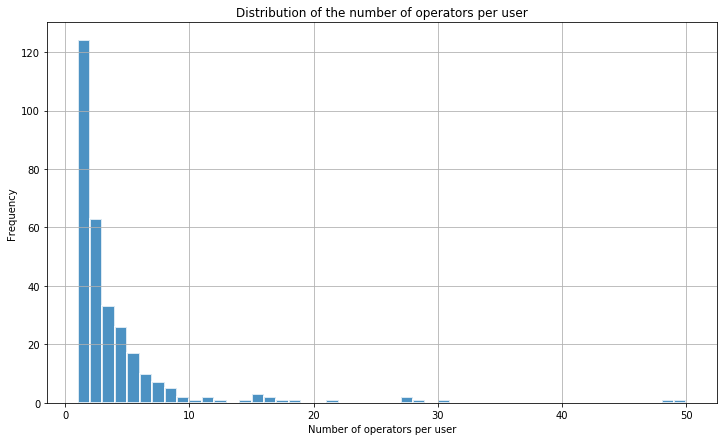

In [33]:
# Let's look at the distribution of the number of operators per user
fig, ax = plt.subplots(figsize=(12, 7))
df[df.operator_id.notnull()].groupby(['user_id']).operator_id.nunique()\
    .hist(bins=49, alpha=0.8, linewidth=2, edgecolor='w', ax=ax);
ax.set_title('Distribution of the number of operators per user')
ax.set_xlabel('Number of operators per user')
ax.set_ylabel('Frequency');

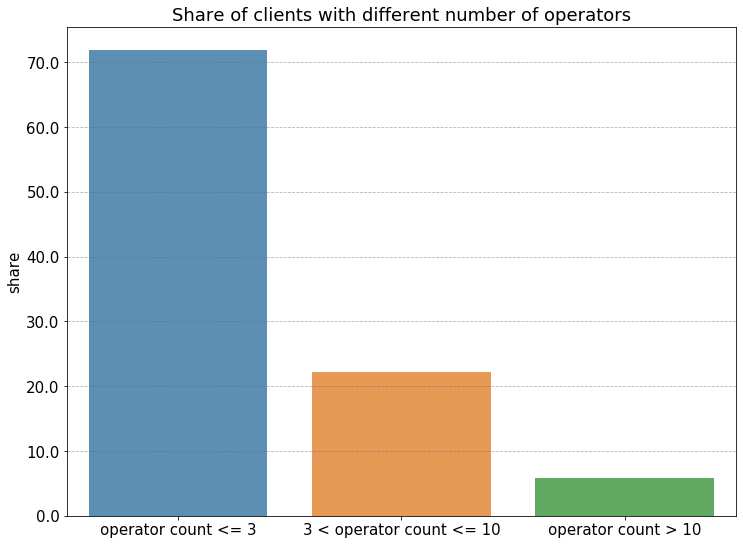

In [34]:
# Let's plot the distribution of the number of operators per user by category 
fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x='labels', y='share', ax=ax, alpha=0.8,
            data=(df[df.operator_id.notnull()].groupby(['user_id']).operator_id.nunique()\
                    .value_counts(bins=[1, 3, 10, 50], normalize=True).to_frame().round(3)*100)\
                    .reset_index().rename(columns={'index':'labels','operator_id':'share'}))
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_title('Share of clients with different number of operators', size = 18)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.set_xticklabels(['operator count <= 3', '3 < operator count <= 10', 'operator count > 10'], size = 15)
ax.set_ylabel(ax.get_ylabel(), size = 15)
ax.set_xlabel('');

Basically, clients have a small number of operators, very rarely there are more than 10. Individual clients have about 30 or 50 operators.

__Estimate the share of non-optimal use of tariff plans among all clients and among consumers of each type of tariff (plan A, plan B, plan C).__

In [35]:
# Let's estimate the share of non-optimal use of tariff plans among active clients.
users_non_opt = costs_cum[costs_cum.user_id.isin(active_clients)].query('opt_tariff!=tariff_plan').user_id.count()
print(BOLD + 'The number of active clients who use non-optimal tariff plan is {}'.format(users_non_opt)
           + ', which is {:.1%} of all active clients.'.format(users_non_opt/len(active_clients)), END) 

The number of active clients who use non-optimal tariff plan is 127, which is 47.2% of all active clients. 


Almost half of active clients use a non-optimal tariff plan.

In [36]:
# Let's estimate the share of non-optimal use of tariff plans by tariff plans
costs_cum['non_optimal'] = costs_cum.tariff_plan != costs_cum.opt_tariff

non_opt_by_tariffs = costs_cum[costs_cum.user_id.isin(active_clients)]\
                        .groupby('tariff_plan').agg({'non_optimal':['sum', 'count']})
non_opt_by_tariffs.columns = ['clients with non-optinal plans', 'all clients']
non_opt_by_tariffs['clients with non-optinal plans'] = non_opt_by_tariffs['clients with non-optinal plans'].astype(int)
non_opt_by_tariffs['share'] = 100 * non_opt_by_tariffs['clients with non-optinal plans']\
                                    / non_opt_by_tariffs['all clients']
print(BOLD + 'Share of non-optimal use of tariff plans by tariff plans:' + END)
display(non_opt_by_tariffs.round(1))

Share of non-optimal use of tariff plans by tariff plans:


,clients with non-optinal plans,all clients,share
tariff_plan,,,
A,28,29,96.6
B,97,98,99.0
C,2,142,1.4


Most of clients using tariff plan C have the optimal choice. Most users of other plans have a non-optimal tariff.

In [37]:
# Let's estimate the number of active clients who use non-optimal tariff plan for each type of plan.
print(BOLD + 'Correspondence of the optimal tariff for each type of tariff plan used by customers.' + END)
tariff_needs = costs_cum[costs_cum.user_id.isin(active_clients)]\
                    .pivot_table(index='tariff_plan', columns='opt_tariff',
                                 values='user_id', aggfunc='count').fillna(0).astype(int)
display(tariff_needs)

Correspondence of the optimal tariff for each type of tariff plan used by customers.


opt_tariff,A,B,C
tariff_plan,,,
A,1,1,27
B,0,1,97
C,0,2,140


In [38]:
# Let's show the table with larger fond for presentation
tariff_needs.columns=pd.MultiIndex.from_tuples([('Optimal Tariff Plan', 'Plan A'),
                                                ('Optimal Tariff Plan', 'Plan B'),
                                                ('Optimal Tariff Plan', 'Plan C')])
tariff_needs.index.rename('Current Plan', inplace=True)
heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '18px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

tariff_needs.style.set_table_styles(dfstyle)

The tariff plan C (the smallest) is optimal for almost all users. It is profitable for 27 clients with tariff plan A and 97 clients with tariff plan B to switch to it.

The tariff plan B is optimal only for 4 clients. It is profitable for 2 clients with tariff plan C and one client with tariff plan A to switch to it. 

The tariff plan A is optimal for only one client and he or she use it.

__Estimating additional revenue from customers using non-optimal tariffs and its destribution by tariff plans. Determining what tariff brings the most benefit from the non-optimal use of the tariff plan.__

In [39]:
# Let's estimate additional revenue from customers using non-optimal tariffs
additional_revenue = costs.groupby(costs.date.dt.to_period('M'))\
                        .agg({'additional_revenue':'sum', 'tariff_cost':'sum'})
additional_revenue.loc['total'] = additional_revenue.sum()
additional_revenue['additional_revenue_perc'] = 100 * additional_revenue.additional_revenue\
                                                    / additional_revenue.tariff_cost
print(BOLD + 'Additional revenue from customers using non-optimal tariffs and its share in the total revenue:' + END)
display(additional_revenue.round(2))

Additional revenue from customers using non-optimal tariffs and its share in the total revenue:


,additional_revenue,tariff_cost,additional_revenue_perc
date,,,
2019-08,73582.52,185899.34,39.58
2019-09,136012.69,405680.82,33.53
2019-10,204419.01,651326.44,31.39
2019-11,192437.65,635737.63,30.27
total,606451.87,1878644.23,32.28


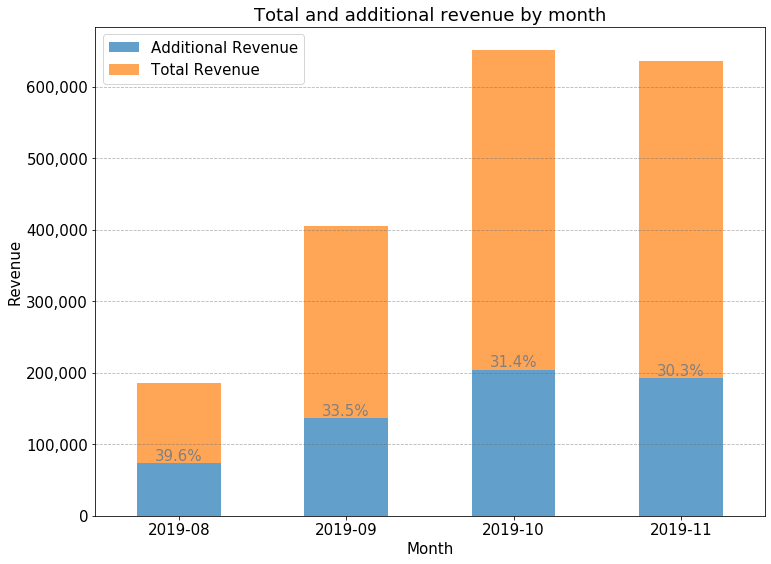

In [40]:
# Let's plot the corresponding chart
fig, ax = plt.subplots(figsize=(12, 9))
additional_revenue['Total Revenue'] = additional_revenue.tariff_cost - additional_revenue.additional_revenue
additional_revenue[['additional_revenue', 'Total Revenue']][:-1]\
    .rename(columns={'additional_revenue':'Additional Revenue'})\
    .plot(kind='bar', stacked=True, alpha=0.7, ax=ax);
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_title('Total and additional revenue by month', size = 18)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.set_xticklabels(additional_revenue.index, size = 15)
ax.set_xlabel('Month', size = 15)
ax.set_ylabel('Revenue', size = 15);
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(rotation=0)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
rects = ax.patches
labels = [str(x)+'%' for x in additional_revenue['additional_revenue_perc'][:-1].round(1)]
for rect, label in zip(rects[:len(labels)], labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 30, label,
            ha='center', va='bottom', size=15, c='gray')

In general, additional revenue from the use of non-optimal tariffs by clients is 32% of the total revenue of the service, which is a significant share. In August this share was almost 40% and by November it had dropped to 30%.

The total revenue of the service doubled in September, additional revenue from the use of non-optimal tariffs by clients grew slightly less, in October both values increased by 1.5 times and stopped growing.

In [41]:
# Let's look at the number of clients, the number of their operators, the number and duration of their calls by month. 
print(BOLD + 'The number of clients, the number of their operators, the number and duration of their calls by month' + END)
display(costs.groupby(costs.date.dt.to_period('M'))\
            .agg({'user_id':'count', 'operator_count':'sum', 'call_duration':'sum', 'calls_count':'sum'}).round(1))

The number of clients, the number of their operators, the number and duration of their calls by month


,user_id,operator_count,call_duration,calls_count
date,,,,
2019-08,85,178,13636.9,11833.0
2019-09,176,475,73197.5,70702.0
2019-10,274,813,147161.4,182982.0
2019-11,260,821,170018.1,206318.0


The growth in revenue is due to the growth in the number of clients of the service, the growth in the number of operators and the number and duration of their calls. This is because we are only looking at customers who registered after August 1, 2019.

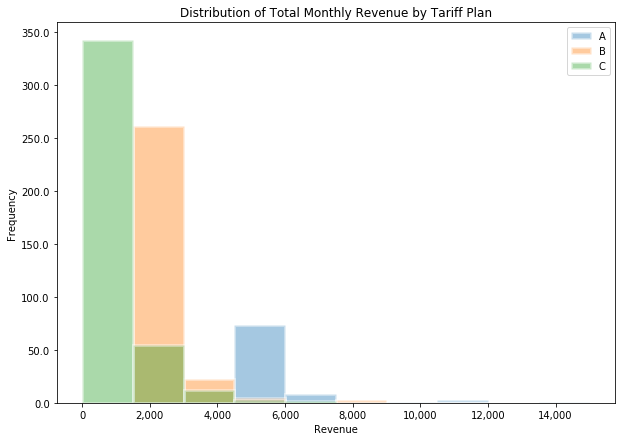

In [42]:
# Let's look at revenue by tariff plans
fig, ax = plt.subplots(figsize=(10, 7))
for group, group_data in costs.groupby('tariff_plan'):
    group_data.tariff_cost.hist(alpha=0.4, linewidth=3, edgecolor='w', label=group, ax=ax, range=(0, 15000))
ax.legend() 
ax.grid(b=None)
ax.set_xlabel('Revenue')
ax.set_ylabel('Frequency')
ax.set_xticklabels(ax.get_xticks())
ax.set_yticklabels(ax.get_yticks())
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Distribution of Total Monthly Revenue by Tariff Plan');

Revenue from a client with tariff A - the highest, with tariff C - the least.

In [44]:
# Let's look at additional revenue distributed by tariff plans
additional_revenue_by_plan = round(costs.pivot_table(index='date', columns='tariff_plan',
                                                     values='additional_revenue', aggfunc='sum')\
                                .div(costs.groupby('date').additional_revenue.sum(), axis=0), 3)*100
additional_revenue_by_plan.set_index(additional_revenue_by_plan.index.strftime('%Y-%m'), inplace=True)
additional_revenue_by_plan.loc['total'] = round(costs.groupby('tariff_plan').additional_revenue.sum()\
                                                /costs.additional_revenue.sum(), 3) * 100 
print(BOLD + 'Share of additional revenue by tariff plans' + END)
display(additional_revenue_by_plan)

Share of additional revenue by tariff plans


tariff_plan,A,B,C
2019-08,54.3,45.7,0.0
2019-09,53.8,45.7,0.5
2019-10,57.4,42.3,0.3
2019-11,54.1,45.9,0.0
total,55.2,44.6,0.2


The additional revenue from the use of non-optimal tariffs by clients is divided between tariffs A and B. The shares change slightly over time. The share of tariff A is a little higher.

__Ploting the distribution of additional revenue from a client due to using non-optimal tariffs.__

Distribution of additional revenue from the use of non-optimal tariffs by clients


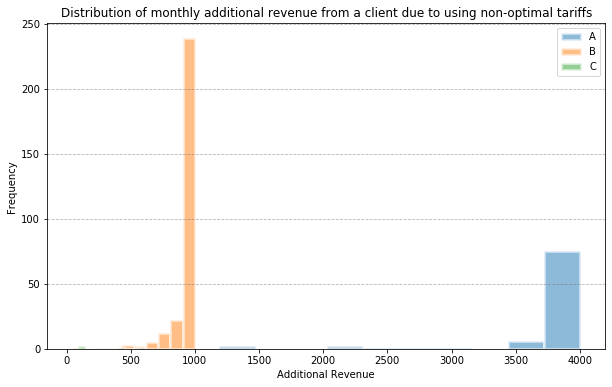

In [45]:
# Let's look at distribution of additional revenue from the use of non-optimal tariffs by clients
print(BOLD + 'Distribution of additional revenue from the use of non-optimal tariffs by clients' + END)
fig, ax = plt.subplots(figsize=(10, 6))
for group, group_data in costs[costs.additional_revenue>0].groupby('tariff_plan'):
    group_data.additional_revenue.hist(alpha=0.5, linewidth=3, edgecolor='w',
                                                          label=group, ax=ax)
plt.legend(); 
ax.grid(b=None)
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_title('Distribution of monthly additional revenue from a client due to using non-optimal tariffs')
ax.set_xlabel('Additional Revenue')
ax.set_ylabel('Frequency')
plt.show()

Additional revenue from the client due to the use of non-optimal tariffs, mainly due to the difference in the base price of tariffs A and B with the base price of the minimum tariff C, which is 4000 and 1000 units, respectively.

__Estimating the churn rate for clients who use optimal and non-optimal calling plans. Are there any differences in churn among these two groups?__


In [47]:
# Let's estimate the churn rate for clients who use optimal and non-optimal calling plans.
# Defind clients who leave as clients who didn't have reports in the last 30 days.

# determining clients with optimal plans
users_with_opt_plan = costs_cum[costs_cum.tariff_plan == costs_cum.opt_tariff].user_id
# determining clients with non-optimal plans
users_with_nonopt_plan = costs_cum[costs_cum.tariff_plan != costs_cum.opt_tariff].user_id

print(BOLD + 'The number of clients who did not have reports in the last 30 days and its share ' 
           + '\nfor clients who use optimal tariff plan and do not:' + END)
# creating a summary table on the number of clients who didn't have reports in the last 30 days and its share
# for clients who use optimal and non-optimal calling plans
churn_rate = pd.DataFrame({'not active clients': [len(set(users_with_opt_plan) - set(active_clients)),
                                     len(set(users_with_nonopt_plan) - set(active_clients))],
                           'all clients': [len(users_with_opt_plan),
                                           len(users_with_nonopt_plan)],
                           'churn, %': [100 * round(len(set(users_with_opt_plan) - set(active_clients))\
                                                     /len(users_with_opt_plan), 3),
                                        100 * round(len(set(users_with_nonopt_plan) - set(active_clients))\
                                                     /len(users_with_nonopt_plan), 3)]},
                           index=['with_opt_plan', 'with_non-opt_plan'])
display(churn_rate)

The number of clients who did not have reports in the last 30 days and its share 
for clients who use optimal tariff plan and do not:


,not active clients,all clients,"churn, %"
with_opt_plan,19,161,11.8
with_non-opt_plan,18,145,12.4


In [48]:
# Let's show the table with larger fond for presentation
churn_rate.rename(index={'with_opt_plan': 'clients using optimal tariff',
                         'with_non-opt_plan':'clients using non-optimal tariff'}, inplace=True)
churn_rate.style.set_table_styles(dfstyle)

,not active clients,all clients,"churn, %"
clients using optimal tariff,19,161,11.8
clients using non-optimal tariff,18,145,12.4


The churn rate of clients using optimal and non-optimal calling plans is almost the same, about 12%.

__Categorizing the clients by total revenue from them. Estimating the share of non-optimal use of tariff plans among these groups. How often do large customers use the optimal calling plan?__

In [49]:
# Let's categorize the clients by total revenue from them
# To do this, let's look at the distribution of the service's revenue by client.

# calculating average client expenses per month
costs_cum['monthly_costs'] = costs_cum.tariff_cost / costs_cum.months_count

# function to calculate 75th percentile
def perc25(series):
    return series.quantile(0.75)

# function to calculate 75th percentile
def perc75(series):
    return series.quantile(0.75)

# function to calculate 95th percentile
def perc95(series):
    return series.quantile(0.95)

print(BOLD + "Main statistics of monthly service revenue by client:" + END)
display(costs_cum.agg({'monthly_costs':['count', 'std', 'min', 'mean', 'median', perc25, perc75, perc95, 'max']}).T)

Main statistics of monthly service revenue by client:


,count,std,min,mean,median,perc25,perc75,perc95,max
monthly_costs,306.0,2121.114499,1100.0,2359.467369,2100.0,2416.395833,2416.395833,5459.081667,21535.19


To divide the revenue from a client into levels, we can take the values of the first and third quartiles, and 95th percentile (see perc25, perc75, perc95).

In [50]:
# Let's categorize the clients by total revenue from them by quartiles 
# calculating quartiles
Q1 = costs_cum.monthly_costs.quantile(0.25)
Q3 = costs_cum.monthly_costs.quantile(0.75)
QUANTILE95 = costs.tariff_cost.quantile(0.95)

# function to categorize clients by revenue from them using quartiles
def revenue_level(revenue):
    if revenue <= Q1:
        return 'low'
    elif revenue <= Q3:
        return 'middle'
    elif revenue <= QUANTILE95:
        return 'high'
    else:
        return 'very high'

# categorizing clients by revenue from them
costs_cum['revenue_level'] = costs_cum.monthly_costs.apply(revenue_level)

# adding order of tariff plans 
costs_cum['opt_tariff'] = pd.Categorical(costs_cum.opt_tariff, ordered=True, categories=['C', 'B', 'A'])
costs_cum['tariff_plan'] = pd.Categorical(costs_cum.tariff_plan, ordered=True, categories=['C', 'B', 'A'])

# determining whether the current plan is optimal or the client needs a smaller or bigger tariff plan 
costs_cum['optimal'] = np.where(costs_cum.opt_tariff==costs_cum.tariff_plan, 'optimal', 
                           np.where(costs_cum.opt_tariff>costs_cum.tariff_plan, 'need bigger', 'need smaller'))

print(BOLD 
    + 'The number of clients of each category by their expenses having optimal plan or needing smaller or bigger one'
    + END)
display(costs_cum.pivot_table(index='revenue_level', columns='optimal', values='user_id', aggfunc='count')\
            .fillna(0).astype(int).loc[['low', 'middle', 'high', 'very high']])
print()

print(BOLD 
    + 'Share of clients of each category by their expenses having optimal plan or needing smaller or bigger one'
    + END)
display(100 * costs_cum.pivot_table(index='revenue_level', columns='optimal', values='user_id', aggfunc='count')\
                .fillna(0).div(costs_cum.groupby('revenue_level').user_id.count(), axis=0).round(3)\
            .loc[['low', 'middle', 'high', 'very high']])

The number of clients of each category by their expenses having optimal plan or needing smaller or bigger one


optimal,need bigger,need smaller,optimal
revenue_level,,,
low,0,0,77
middle,0,79,73
high,1,52,9
very high,1,12,2



Share of clients of each category by their expenses having optimal plan or needing smaller or bigger one


optimal,need bigger,need smaller,optimal
revenue_level,,,
low,0.0,0.0,100.0
middle,0.0,52.0,48.0
high,1.6,83.9,14.5
very high,6.7,80.0,13.3


Clients having optimal tariff plans are not large clients of the telephony service. For clients who bring more revenue, as a rule, a lower tariff is more optimal.

In [51]:
# Let's look at each category of clients by thier tariff plans
print(BOLD + 'The number of clients of each category by their expenses in each tariff plan:' + END)
display(costs_cum.pivot_table(index='revenue_level', columns='tariff_plan', values='user_id', aggfunc='count')\
        .fillna(0).astype(int).loc[['low', 'middle', 'high', 'very high']])

print(BOLD + 'Share of clients of each category by their expenses in each tariff plan:' + END)
display(100 * costs_cum.pivot_table(index='revenue_level', columns='tariff_plan', values='user_id', aggfunc='count')\
              .fillna(0).div(costs_cum.groupby('revenue_level').user_id.count(), axis=0).round(3)\
        .loc[['low', 'middle', 'high', 'very high']])

The number of clients of each category by their expenses in each tariff plan:


tariff_plan,C,B,A
revenue_level,,,
low,77,0,0
middle,73,79,0
high,10,32,20
very high,1,1,13


Share of clients of each category by their expenses in each tariff plan:


tariff_plan,C,B,A
revenue_level,,,
low,100.0,0.0,0.0
middle,48.0,52.0,0.0
high,16.1,51.6,32.3
very high,6.7,6.7,86.7


Customers with the lowest tariffs bring the lowest revenue. Middle clients in terms of revenue use tariffs B and C in approximately equal shares. Large clients in terms of revenue of the service use tariffs A and B ofter. It looks like clients only bring the largest revenue just because they non-optimally use the biggest tariff plan. Thus, the bigger the tariff plan, the larger level of clients in terns of revenue they bring.

## 5. Testing Hypotheses
<a id='section5'></a>

### Hypothesis1: The amount of additional revenue due to using a non-optimal plan by customers differs depending on the tariff type.

Desciptive statistics for additional revenue for different tariff types:
A


,count,min,max,mean,median,std,var
additional_revenue,90.0,0.0,4000.0,3716.8,3989.4,774.4,599670.2


B


,count,min,max,mean,median,std,var
additional_revenue,291.0,0.0,1000.0,930.3,994.0,168.7,28450.6


C


,count,min,max,mean,median,std,var
additional_revenue,414.0,0.0,605.2,2.9,0.0,36.9,1359.0



Distribution of additional revenue for different tariff types:


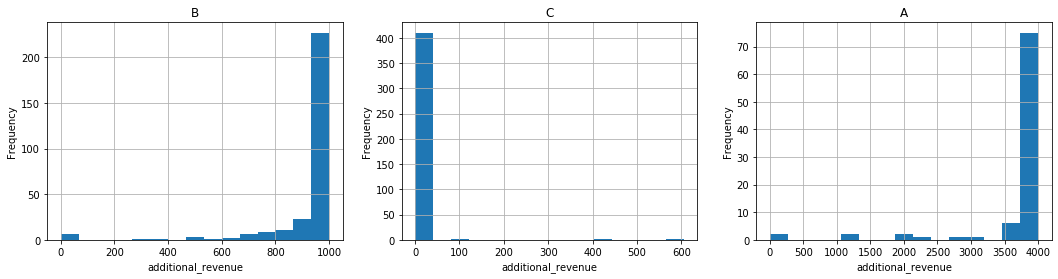

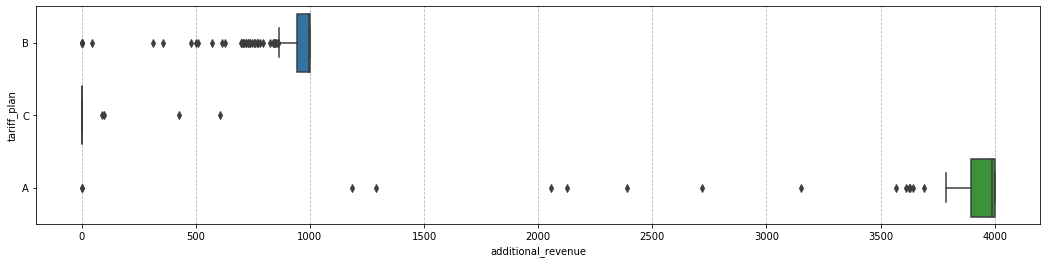

In [52]:
# Let's look at descriptive statictics and distribution of additional revenue for different tariff types 
# function to print the descriptive statistics and distribution of additional revenue for different tariff types  
def descrip_stat_and_distr(data, feature):
    # printing the descriptive statistics
    print(BOLD + 'Desciptive statistics for additional revenue for different tariff types:' + END)
    for name, group_data in data.groupby('tariff_plan'):
        print(BOLD + name + END)
        display(group_data[[feature]].agg(['count', 'min', 'max', 'mean', 'median', 'std', 'var']).round(1).T)
    print()

    # ploting histograms and boxplots for additional revenue for different tariff types 
    print(BOLD + 'Distribution of additional revenue for different tariff types:' + END)
    cols_num = len(data.tariff_plan.unique())
    fig, axes = plt.subplots(ncols=cols_num, figsize=(6*cols_num, 4))
    for i, value in enumerate(data.tariff_plan.unique()):
        data[data['tariff_plan']==value][feature].hist(ax=axes[i], bins=15)
        axes[i].set_title(value)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        
    fig, ax = plt.subplots(figsize=(18, 4))
    sns.boxplot(y='tariff_plan', x=feature, data=data, ax=ax, orient='h'); 
    ax.grid(axis='x', linestyle='--', color='dimgray', alpha=0.5)


# Let's look at descriptive statistics and distribution for additional revenue by different tariff types 
descrip_stat_and_distr(costs, 'additional_revenue')

The medians for the additional revenue for different tariff types are shifted relative to each other.

The distributions of the additional revenue for each tariff types does not have the form of a normal distribution.

Q-Q Plots for duration of a trip for tariff plan A and tariff plan B and tariff plan C:


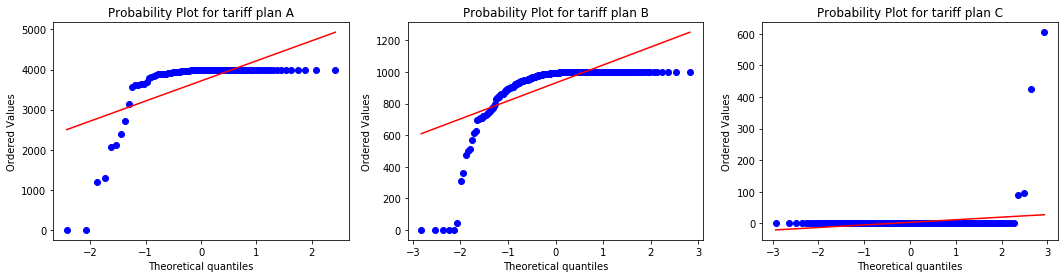

Shapiro-Wilk normality tests:
Hypotheses:
H₀: Aditional revenue for tariff plan A is distributed normally
H₁: Aditional revenue for tariff plan A is not distributed normally
Shapiro-Wilk normality test, p-value:  3.012518337279732e-17
We reject the hypothesis H₀

Hypotheses:
H₀: Aditional revenue for tariff plan B is distributed normally
H₁: Aditional revenue for tariff plan B is not distributed normally
Shapiro-Wilk normality test, p-value:  6.779014005553686e-29
We reject the hypothesis H₀

Hypotheses:
H₀: Aditional revenue for tariff plan C is distributed normally
H₁: Aditional revenue for tariff plan C is not distributed normally
Shapiro-Wilk normality test, p-value:  7.671688702639076e-41
We reject the hypothesis H₀



In [53]:
# Let's formally test the hypothesis that the distributios of samples are normal

# testing the hypotheses of normality of the additional revenue for each tariff types
norm_test([costs[costs.tariff_plan=='A'], costs[costs.tariff_plan=='B'], costs[costs.tariff_plan=='C']],
          ['tariff plan A', 'tariff plan B', 'tariff plan C'], 'Aditional revenue')

The distribution of the additional revenue for each tariff types is most likely different from the normal one, since the points on the Q-Q graph do not lie on a straight line, but are described by a non-linear curve or some of the points lie far from the straight lines.

Shapiro-Wilk normality tests also reject the hypothesis  𝐻0  that the distribution of samples is normal.

Thus, we can not use a parametric Student's t-test in order to compare the additional revenue for different tariff types.

In [54]:
# Let's test statistical significance of еру differences in the amount of additional revenue 
# due to using a non-optimal plan in different tariff plans using Mann-Whitney U test

# running Mann-Whitney U test for the additional revenue for tariff types A and B
mann_whitneyu_test(costs[costs.tariff_plan=='A'].additional_revenue,
                   costs[costs.tariff_plan=='B'].additional_revenue,
                   'additional revenue for tariff plans A and B')
print()

# running Mann-Whitney U test for the additional revenue for tariff types B and C
mann_whitneyu_test(costs[costs.tariff_plan=='B'].additional_revenue,
                   costs[costs.tariff_plan=='C'].additional_revenue,
                   'additional revenue for tariff plans B and C')

Mann-Whitney U test:
Hypotheses:
H₀: Sample distributions of additional revenue for tariff plans A and B are equal.
H₁: Sample distributions of additional revenue for tariff plans A and B are not equal.
Mann-Whitney U test, p-value:  2.2048555964531818e-43
We reject the hypothesis H₀

Mann-Whitney U test:
Hypotheses:
H₀: Sample distributions of additional revenue for tariff plans B and C are equal.
H₁: Sample distributions of additional revenue for tariff plans B and C are not equal.
Mann-Whitney U test, p-value:  2.17939925280685e-137
We reject the hypothesis H₀


The Mann-Whitney U test rejects the null hypothesis about equality of additionaly revenue distributions for tariff plans A and plan B. The additional revenue for plan A is greater than the additional revenue for plan B by almost 3,000 units.

The Mann-Whitney U test rejects the null hypothesis about equality of additionaly revenue distributions for tariff plans B and C. The additional revenue for plan B is greater than the additional revenue for plan C by almost 1,000 units.

### Hypothesis2: The churn of users who used non-optimal and optimal tariffs differs.

In [55]:
print(BOLD + 'The churn rate for clients who use optimal and non-optimal calling plans:' + END)
print(BOLD + 'Rem: ' + END + "Defind clients who leave as clients who didn't have reports in the last 30 days")
display(churn_rate)
print()

z_test(churn_rate, 'churn of clients who used the non-optimal and optimal tariffs') 

The churn rate for clients who use optimal and non-optimal calling plans:
Rem: Defind clients who leave as clients who didn't have reports in the last 30 days


,not active clients,all clients,"churn, %"
clients using optimal tariff,19,161,11.8
clients using non-optimal tariff,18,145,12.4



Two-Proportions Z-Test:
Hypotheses:
H₀: The proportions of churn of clients who used the non-optimal and optimal tariffs are equal.
H₁: The proportions of churn of clients who used the non-optimal and optimal tariffs are not equal.
The proportion difference z-test, p-value:  0.8696481894552295
We can't reject the hypothesis H₀


Two-proportions z-test doesn't reject the null hypothesis about equality of churn rate for clients who used the non-optimal and optimal tariffs at a significance level of 0.05. Thus, there is likely no difference between the churn.

### Hypothesis3: The share of optimal tariffs for large clients differs from other clients.

In [56]:
# Let's create contingency table for large and not large clients and amount of optimal plans among them.
costs_cum['is_large_client'] = (costs_cum.revenue_level == 'high')|(costs_cum.revenue_level == 'very high')
costs_cum['is_optimal'] = costs_cum.tariff_plan == costs_cum.opt_tariff

optimal_by_client_cat = costs_cum[costs_cum.user_id.isin(active_clients)]\
                        .groupby('is_large_client').agg({'is_optimal':['sum', 'count']})
optimal_by_client_cat.columns = ['clients with optinal plans', 'all clients']
optimal_by_client_cat['clients with optinal plans'] = optimal_by_client_cat['clients with optinal plans'].astype(int)
optimal_by_client_cat['share'] = 100 * optimal_by_client_cat['clients with optinal plans']\
                                    / optimal_by_client_cat['all clients']
print(BOLD + 'The share of optimal tariffs for large clients and not large clients:' + END)
display(optimal_by_client_cat.round(1))
print()

z_test(optimal_by_client_cat, 'optimal tariffs for large and not large clients') 

The share of optimal tariffs for large clients and not large clients:


,clients with optinal plans,all clients,share
is_large_client,,,
False,132,199,66.3
True,10,70,14.3



Two-Proportions Z-Test:
Hypotheses:
H₀: The proportions of optimal tariffs for large and not large clients are equal.
H₁: The proportions of optimal tariffs for large and not large clients are not equal.
The proportion difference z-test, p-value:  6.261657858885883e-14
We reject the hypothesis H₀


Two-proportions z-test rejects the null hypothesis about equality of proportions of optimal tariffs for large and not large clients at a significance level of 0.05. Thus, there is likely some difference between them. The share of optimal plans among large clients is 14.5%, although the share of optimal plans amonth other clients is 66%. Indeed, a significant part of the company's revenue comes from the non-optimal use of tariff plans by large customers.

## 6. Overal Conclutions
<a id='section6'></a>

There is data on the use of the virtual telephony service from August 2nd to November 28th, 2019 by operators of 307 clients who registered from August 1st to October 31st, 2019.

__Before proceeding to the analysis, the data was preprocessed__:
* After a general review of the data revealed:
    - columns with excess types
    - misssing values for operator identifiers almost for all clients (Most null values correspond to missed calls, which explains the absence of an operator ID. There are no operator ID for customers with only one operator.)
    - missing values for the column with internal or external type of a call (Most missing value correspond incoming or/and missed calls, which are free, so it doesn't affect calculations of the cost of calls)
    - 10% completely duplicated rows in the table with client reports
    - a client whose operators have an abnormal long call duration
    - reports with missed calls haveing a non-zero call duration
* The some types were converted to appropriate ones.
* The missing values were filled in so that further calculations of the cost of communication services were calculated correctly (so that all operators were taken into account).
* The completely duplicate rows were removed.
* The customer whose operators had an abnormally long call duration was removed from consideration.
* The duration of the call indicated as missed was set to zero.
* For further analysis, monthly duration of outgoing internal and external calls, monthly cost of calls, monthly cost of operators, monthly cost of communication services and optimal tariff plan for each client and additional revenue of the service from client using non-optimal tariffs as well.

__Some general information about data__:

* There are three types of tariff plans in the dataset (calling plans A, B and C, the first one is the biggest).
* Clients do not have reports every day.
* 88% of clients had reports on calls last 30 days
* Almost 30% of clients have only incoming calls
* Only 2.5% of all answered calls are internal, the duration of which is not longer a minute.
* A client has 2 operators, on average. Only 5% of clients have more than 10 operators.
* An average operator makes 35 calls a month and calls for a total of 40 minutes per month.

During the __EDA on optimality of the tariff plan for clients and additional revenue from clients at non-optimal tariffs__, the following patterns were identified:
* The avarage cost of calls does not differ much in different tariffs and is not comparable to the cost of the basic price of plans (the average cost of all calls per month is 1000 times less than the monthly fee).
* The monthly fee in each tariff, on average, consists only of the monthly base price of the tariff and the cost of connected operators.
* Average extra revenue from each client using a non-optimal tariff is about 760 units.
* Almost half of active clients use a non-optimal tariff plan.
* The tariff plan C (the smallest) is optimal for almost all users. Tariff plan B is optimal only for 4 clients. Tariff plan A is optimal for only one client.
* Additional revenue from the use of non-optimal tariffs by clients is about 30% of the total revenue of the service.
* The additional revenue from the use of non-optimal tariffs by customers is divided between only tariffs A and B almost equally.
* Additional revenue from the client due to the use of non-optimal tariffs, mainly due to the difference in the base price of tariffs A and B with the base price of the minimum tariff C, which is 4000 and 1000 units, respectively.
* A small share of large customers (in terms of the cost of communication services) have an optimal tariff.
* On average, the additional revenue for plan A is statistically significantly greater than those in group B, while the additional revenue for plan B is statistically significantly greater than those in group C.
* There are no statistically significantly differences in the churn of clients using optimal and non-optimal tariff plans. The churn rate is about 12%.
* The share of optimal tariff plans for large clients is statistically significantly lower than for other clients.

__Recommendations__
* 30% of the revenue comes from clients using non-optimal plans, which is pretty high. If all clients switch to the optimal tariff, the revenue will drop sharply. Since this churn is no different for optimal and non-optimal users, we can assume that the risk of that switch is quite low. 
* It makes sense to understand why clients have chosen the most expensive plan, so probably the cost is not a factor here, so they are probably ready to pay even more. So I would recommend to think about new plan with even higher base price. 
* Churn is 12% - that indicator should be compared with the competitors. Increasing of the loyalty will have an impact on the revenue accordingly.  